## Fusion Jupyter demo with sklearn

### Spark Context is available as Spark

1. Load data from signals
2. Print the columns
3. Do some basic statitics
4. Display a basic graph
6. Load the training collection for query intent classification job
7. Train a RandomForest Classifier with CV/ Model Stability Graph/ Plot Confusion matrix etc

##### Standard imports for python, spark, sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql.functions import *
from pyspark.sql.types import StringType


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

##### Read data from Fusion as a SparkDF

In [3]:
df_training = spark.read.load(format='solr',
                         collection="ecommerce_training",
                         zkhost="localhost:9983/lwfusion/4.2.0-SNAPSHOT/solr",
                         flatten_multivalued='false',
                         request_handler='/select',
                         query="query:*\:*"
                         )

In [4]:
df_training.printSchema()

root
 |-- aggr_id_s: string (nullable = true)
 |-- aggr_job_id_s: string (nullable = true)
 |-- aggr_type_s: string (nullable = true)
 |-- category: string (nullable = true)
 |-- department: string (nullable = true)
 |-- flag_s: string (nullable = true)
 |-- id: string (nullable = false)
 |-- query: string (nullable = true)
 |-- query_t: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- timestamp_tdt: timestamp (nullable = true)



In [5]:
df_training = df_training.select("department","query","id")

In [6]:
df_training.show(10)

+--------------------+--------------------+--------------------+
|          department|               query|                  id|
+--------------------+--------------------+--------------------+
|  VIDEO/COMPACT DISC|  x-men: first class|0012646e-fd4e-48f...|
|  VIDEO/COMPACT DISC|angel: season 6an...|003bbf8b-812c-45f...|
|           COMPUTERS|        sku: 3438674|003daa7e-6efe-43e...|
|  VIDEO/COMPACT DISC|iion king 2: simb...|0067cb24-836d-489...|
|INTERACTIVE SOFTWARE| batman: arkham city|006f6c20-16ed-4a4...|
|DIGITAL COMMUNICATIO|       sansung:)t359|00a3902c-2b95-416...|
|INTERACTIVE SOFTWARE|call of duty: mod...|00bac967-f2c9-48d...|
|INTERACTIVE SOFTWARE| batman: arkham city|00cd9e95-310b-4dc...|
|  VIDEO/COMPACT DISC|          csi: miami|010948da-c110-49c...|
|           COMPUTERS|        sku: 2762943|01a26043-fc2c-46b...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



In [7]:
df_training.select("department").distinct().show()

+--------------------+
|          department|
+--------------------+
|         ACCESSORIES|
|           APPLIANCE|
|                null|
|           COMPUTERS|
|MAGNOLIA HOME THEATR|
|   PHOTO/COMMODITIES|
|DIGITAL COMMUNICATIO|
|   COMPUTER SOFTWARE|
|  VIDEO/COMPACT DISC|
|                 DTS|
|               AUDIO|
|INTERACTIVE SOFTWARE|
|               VIDEO|
|        MOBILE AUDIO|
+--------------------+



In [8]:
stats_pd_df = df_training.groupBy("department").count().orderBy(desc("count")).toPandas()

In [9]:
stats_pd_df

,department,count
0,VIDEO/COMPACT DISC,1646
1,INTERACTIVE SOFTWARE,642
2,COMPUTERS,276
3,VIDEO,82
4,PHOTO/COMMODITIES,58
5,AUDIO,40
6,APPLIANCE,36
7,DIGITAL COMMUNICATIO,26
8,MOBILE AUDIO,20
9,ACCESSORIES,16


[]

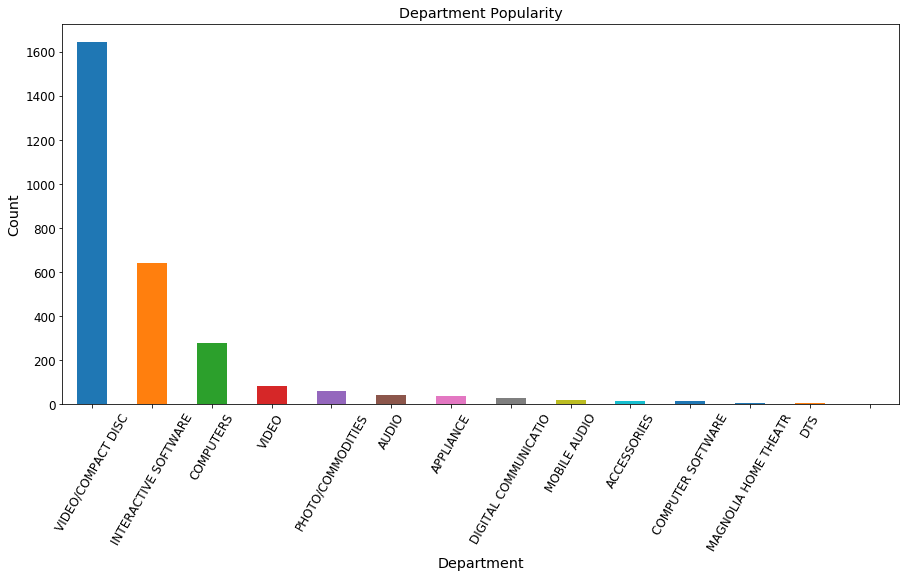

In [10]:
ax= stats_pd_df.plot(x="department",y="count",legend=None,figsize=(15,7),fontsize=12,kind="bar")
ax.set(xlabel="Department", ylabel="Count", title="Department Popularity")
ax.set(title="Department Popularity")
ax.set_xticklabels(stats_pd_df["department"],rotation=60)
ax.plot()

In [11]:
df_training = df_training.dropna(subset=["department","query"])
department_count_df = df_training.groupBy("department").count().orderBy(desc("count"))
department_count_df.show()

+--------------------+-----+
|          department|count|
+--------------------+-----+
|  VIDEO/COMPACT DISC| 1646|
|INTERACTIVE SOFTWARE|  642|
|           COMPUTERS|  276|
|               VIDEO|   82|
|   PHOTO/COMMODITIES|   58|
|               AUDIO|   40|
|           APPLIANCE|   36|
|DIGITAL COMMUNICATIO|   26|
|        MOBILE AUDIO|   20|
|   COMPUTER SOFTWARE|   16|
|         ACCESSORIES|   16|
|MAGNOLIA HOME THEATR|    4|
|                 DTS|    4|
+--------------------+-----+



In [12]:
print(df_training.count())
df_training = df_training.join(department_count_df, on="department")
print(df_training.count())

2866
2866


In [13]:
df_training.show(10)

+-----------+--------------------+--------------------+-----+
| department|               query|                  id|count|
+-----------+--------------------+--------------------+-----+
|ACCESSORIES|toshiba- satellit...|22f773e5-e3ae-4a1...|   16|
|ACCESSORIES|toshiba- satellit...|301b4d11-3584-4e2...|   16|
|ACCESSORIES|tilting mount sku...|367f090c-1cbe-474...|   16|
|ACCESSORIES|samsung 5.1 surro...|39d67d57-2871-4db...|   16|
|ACCESSORIES|mini-dvi to video...|408ea96d-74bd-420...|   16|
|ACCESSORIES|yht-495bl | sku: ...|49db9a60-1860-479...|   16|
|ACCESSORIES|mini-dvi to video...|6b58e3ee-61ac-4ce...|   16|
|ACCESSORIES|mini-dvi to video...|fa8b4fe2-6591-4f7...|   16|
|ACCESSORIES|mini-dvi to video...|1392ede7-73c3-4f2...|   16|
|ACCESSORIES|model number:vpce...|18907328-8be9-4b9...|   16|
+-----------+--------------------+--------------------+-----+
only showing top 10 rows



##### Merge categories having less than 200 samples

In [14]:
def merge_categories(department, count):
    if count < 200:
        return "OTHER"
    return department

merge_categories_udf = udf(lambda x,y: merge_categories(x,y), StringType())

In [15]:
df_training.printSchema()

root
 |-- department: string (nullable = true)
 |-- query: string (nullable = true)
 |-- id: string (nullable = false)
 |-- count: long (nullable = false)



In [16]:
df_training = df_training.withColumn("department", merge_categories_udf("department","count")).select("query","department")
df_training.groupBy("department").count().orderBy(desc("count")).show()
df_training.show(10)

+--------------------+-----+
|          department|count|
+--------------------+-----+
|  VIDEO/COMPACT DISC| 1646|
|INTERACTIVE SOFTWARE|  642|
|               OTHER|  302|
|           COMPUTERS|  276|
+--------------------+-----+

+--------------------+----------+
|               query|department|
+--------------------+----------+
|toshiba- satellit...|     OTHER|
|toshiba- satellit...|     OTHER|
|tilting mount sku...|     OTHER|
|samsung 5.1 surro...|     OTHER|
|mini-dvi to video...|     OTHER|
|yht-495bl | sku: ...|     OTHER|
|mini-dvi to video...|     OTHER|
|mini-dvi to video...|     OTHER|
|mini-dvi to video...|     OTHER|
|model number:vpce...|     OTHER|
+--------------------+----------+
only showing top 10 rows



##### Convert to pandas dataframe and train a classifier

In [17]:
pandas_df = df_training.select("query","department").toPandas()
pandas_df.sample(frac=0.01).head()

,query,department
409,call of duty: world at war- wii,OTHER
2860,transformers: dark of the moon,OTHER
2482,batman: arkham city,INTERACTIVE SOFTWARE
1124,transformers: dark of the moon,VIDEO/COMPACT DISC
2263,batman arkham city: collectors addition,INTERACTIVE SOFTWARE


##### Vectorize the query field

In [18]:
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(pandas_df["query"])
y = pandas_df['department']
print(X.shape, y.shape)

(2866, 1496) (2866,)


##### You can do undersampling/oversampling StratifiedKfold etcs.
##### For simplicity we will just split 10% data for validation

In [19]:
X.shape, y.shape

((2866, 1496), (2866,))

In [20]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42, stratify=y)
y_train.shape, y_test.shape

((2292,), (574,))

##### Train a RandomForestClassifier

In [21]:
rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)

In [22]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

##### Make predictions and evaluate

In [23]:
test_preds = rf.predict(X_test)

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 47   0   8   0]
 [  0 114   4  11]
 [  2   0  54   4]
 [  0   2   0 328]]
Normalized confusion matrix
[[0.85 0.   0.15 0.  ]
 [0.   0.88 0.03 0.09]
 [0.03 0.   0.9  0.07]
 [0.   0.01 0.   0.99]]


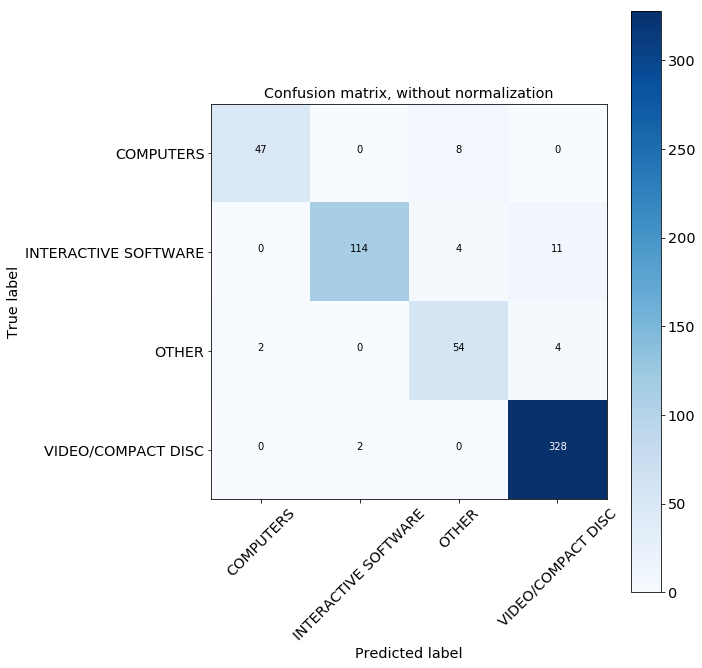

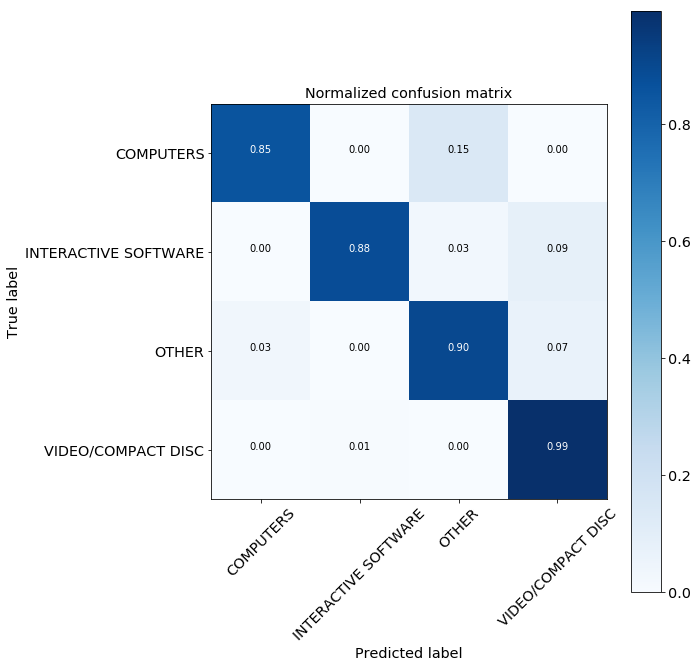

In [25]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, test_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_test),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_test), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
from xgboost.sklearn import XGBClassifier

In [ ]:
xgbc = XGBClassifier(n_estimators=50)
xgbc.fit(X_train, y_train)

In [ ]:
xgbc_test_preds = xgbc.predict(X_test)

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, xgbc_test_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_test),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_test), normalize=True,
                      title='Normalized confusion matrix')

plt.show()